In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [8]:
# Load datasets
data_dir = "/home/vivian.chu/vivian-sandbox/other/xAI-cancer-competition/.data"
train_data = pd.read_csv(f"{data_dir}/train.csv")
train_targets = pd.read_csv(f"{data_dir}/train_targets.csv")
test_data = pd.read_csv(f"{data_dir}/test.csv")

In [9]:
# Clean column names and merge targets with train data
train_data.rename(columns={'Unnamed: 0': 'sample'}, inplace=True)
train_data['sample'] = train_data['sample'].astype(str)
train_targets['sample'] = train_targets['sample'].astype(str)
test_data['sampleId'] = test_data['sampleId'].astype(str)

In [10]:
train_merged = train_data.merge(train_targets[['sample', 'AAC']], left_on='sample', right_on='sample')
train_merged.shape

(742, 19922)

In [11]:
# Prepare train and test datasets
train_features = train_merged.drop(columns=['sample', 'AAC'])
train_labels = train_merged['AAC']
test_features = test_data.drop(columns=['sampleId'])

# Set input dimension
input_dim = train_features.shape[1]

In [12]:
# Split dataset into train and validation (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

In [13]:
# Define the Dataset class
class GeneExpressionDataset(Dataset):
    def __init__(self, data, targets=None):
        self.data = data.values.astype(np.float32)
        self.targets = targets.values.astype(np.float32) if targets is not None else None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.targets is not None:
            return torch.tensor(self.data[idx]), torch.tensor(self.targets[idx])
        else:
            return torch.tensor(self.data[idx])

In [14]:
# Create Dataset and DataLoader objects
train_dataset = GeneExpressionDataset(X_train, y_train)
val_dataset = GeneExpressionDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Reduced batch size to introduce more training noise
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(GeneExpressionDataset(test_features), batch_size=16, shuffle=False)


In [15]:
# Define the model with Transformer and additional improvements
class DrugResponseModel(nn.Module):
    def __init__(self, input_dim, embed_dim=256, num_heads=8, num_layers=4, ff_dim=64, dropout=0.1):
        super(DrugResponseModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = nn.Parameter(torch.randn(1, embed_dim))
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=num_layers)
        self.fc1 = nn.Linear(embed_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim, eps=1e-6)

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding  # Embedding with positional encoding
        x = self.layer_norm(x)  # Layer normalization instead of batch normalization
        x = x.unsqueeze(1)  # Add sequence dimension
        x = self.transformer(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [16]:
# Training loop with improved model
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50, early_stopping_patience=10):
    train_corrs = []
    val_corrs = []
    best_val_corr = -1
    patience_counter = 0
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            # Adding Gaussian noise to features to help reduce overfitting
            features += torch.normal(0, 0.01, size=features.shape).to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs.view(-1), labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs.view(-1), labels)
                val_loss += loss.item()

        # Calculate Spearman correlation for both training and validation sets
        train_corr = evaluate_model(model, train_loader, print_corr=False)
        val_corr = evaluate_model(model, val_loader, print_corr=False)
        train_corrs.append(train_corr)
        val_corrs.append(val_corr)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}, Train Corr: {train_corr:.4f}, Val Corr: {val_corr:.4f}')
        
        # Scheduler step
        scheduler.step(val_corr)

        # Early Stopping Logic
        if val_corr > best_val_corr:
            best_val_corr = val_corr
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # Plot Spearman correlation
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_corrs) + 1), train_corrs, label='Train Spearman Correlation')
    plt.plot(range(1, len(val_corrs) + 1), val_corrs, label='Validation Spearman Correlation')
    plt.xlabel('Epoch')
    plt.ylabel('Spearman Correlation')
    plt.title('Spearman Correlation Over Epochs')
    plt.legend()
    plt.show()

In [17]:
# Evaluation function
def evaluate_model(model, loader, print_corr=True):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.view(-1).cpu().numpy())
    spearman_corr, _ = spearmanr(all_labels, all_preds)
    if spearman_corr is None or np.isnan(spearman_corr):
        spearman_corr = -1  # Set a default value if correlation cannot be computed
    if print_corr:
        print(f'Spearman Correlation: {spearman_corr:.4f}')
    return spearman_corr

In [18]:
# Hyperparameter Sweep
param_grid = {
    'embed_dim': [256],
    'num_heads': [8],
    'num_layers': [2,4],
    'ff_dim': [64,128],
    'dropout': [0.1],
    'learning_rate': [0.00001]
}

best_val_corr = -1
best_params = None


Training with parameters: {'dropout': 0.1, 'embed_dim': 256, 'ff_dim': 64, 'learning_rate': 1e-05, 'num_heads': 8, 'num_layers': 2}


/home/vivian.chu/conda/envs/xai/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/vivian.chu/conda/envs/xai/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/25, Train Loss: 0.0169, Validation Loss: 0.0067, Train Corr: 0.3432, Val Corr: 0.3116
Epoch 2/25, Train Loss: 0.0117, Validation Loss: 0.0062, Train Corr: 0.4723, Val Corr: 0.3265
Epoch 3/25, Train Loss: 0.0102, Validation Loss: 0.0065, Train Corr: 0.5186, Val Corr: 0.3533
Epoch 4/25, Train Loss: 0.0093, Validation Loss: 0.0061, Train Corr: 0.5282, Val Corr: 0.3380
Epoch 5/25, Train Loss: 0.0086, Validation Loss: 0.0062, Train Corr: 0.5613, Val Corr: 0.3635
Epoch 6/25, Train Loss: 0.0082, Validation Loss: 0.0060, Train Corr: 0.5789, Val Corr: 0.3594
Epoch 7/25, Train Loss: 0.0083, Validation Loss: 0.0061, Train Corr: 0.6046, Val Corr: 0.3772
Epoch 8/25, Train Loss: 0.0082, Validation Loss: 0.0065, Train Corr: 0.6147, Val Corr: 0.3549
Epoch 9/25, Train Loss: 0.0077, Validation Loss: 0.0058, Train Corr: 0.6291, Val Corr: 0.3775
Epoch 10/25, Train Loss: 0.0074, Validation Loss: 0.0059, Train Corr: 0.6312, Val Corr: 0.3977
Epoch 11/25, Train Loss: 0.0071, Validation Loss: 0.0057, T

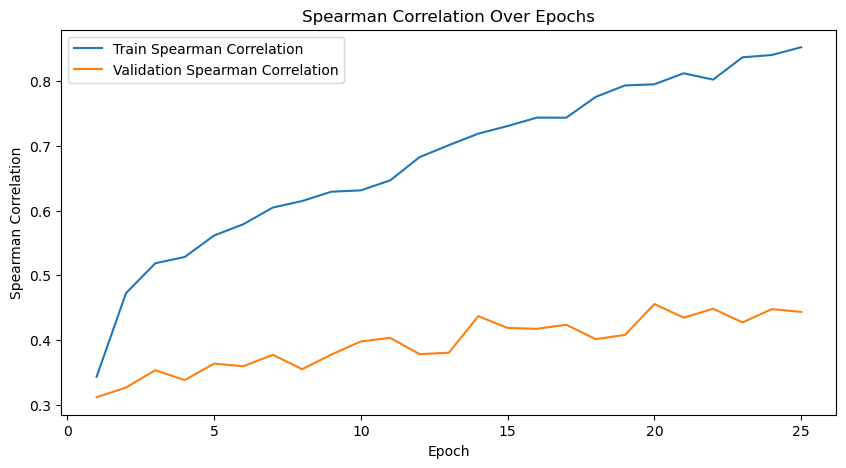

Spearman Correlation: 0.4433
Training with parameters: {'dropout': 0.1, 'embed_dim': 256, 'ff_dim': 64, 'learning_rate': 1e-05, 'num_heads': 8, 'num_layers': 4}


/home/vivian.chu/conda/envs/xai/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/25, Train Loss: 0.0122, Validation Loss: 0.0075, Train Corr: 0.3928, Val Corr: 0.3322
Epoch 2/25, Train Loss: 0.0106, Validation Loss: 0.0062, Train Corr: 0.4598, Val Corr: 0.3557
Epoch 3/25, Train Loss: 0.0102, Validation Loss: 0.0063, Train Corr: 0.4818, Val Corr: 0.3512
Epoch 4/25, Train Loss: 0.0098, Validation Loss: 0.0059, Train Corr: 0.4950, Val Corr: 0.3695
Epoch 5/25, Train Loss: 0.0087, Validation Loss: 0.0060, Train Corr: 0.5420, Val Corr: 0.3936
Epoch 6/25, Train Loss: 0.0089, Validation Loss: 0.0058, Train Corr: 0.5432, Val Corr: 0.3679
Epoch 7/25, Train Loss: 0.0092, Validation Loss: 0.0058, Train Corr: 0.5580, Val Corr: 0.4130
Epoch 8/25, Train Loss: 0.0091, Validation Loss: 0.0058, Train Corr: 0.5757, Val Corr: 0.3892
Epoch 9/25, Train Loss: 0.0084, Validation Loss: 0.0059, Train Corr: 0.5760, Val Corr: 0.4186
Epoch 10/25, Train Loss: 0.0086, Validation Loss: 0.0058, Train Corr: 0.6056, Val Corr: 0.4220
Epoch 11/25, Train Loss: 0.0081, Validation Loss: 0.0058, T

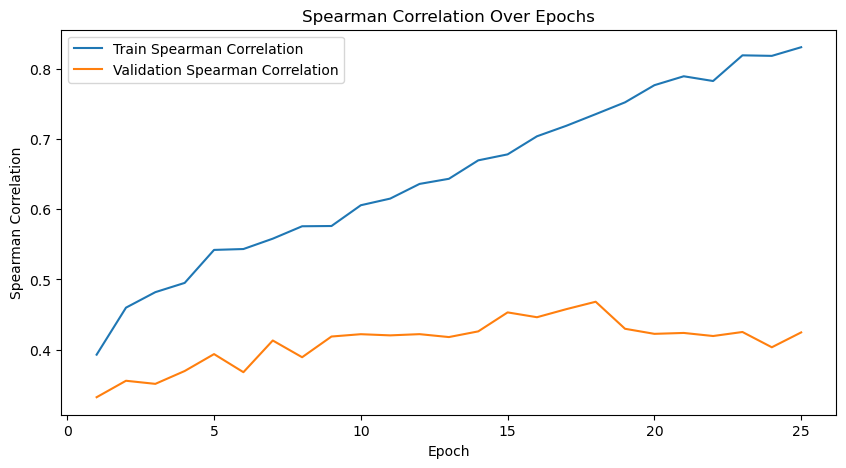

Spearman Correlation: 0.4245
Training with parameters: {'dropout': 0.1, 'embed_dim': 256, 'ff_dim': 128, 'learning_rate': 1e-05, 'num_heads': 8, 'num_layers': 2}
Epoch 1/25, Train Loss: 0.0130, Validation Loss: 0.0079, Train Corr: 0.4142, Val Corr: 0.2017
Epoch 2/25, Train Loss: 0.0101, Validation Loss: 0.0067, Train Corr: 0.4627, Val Corr: 0.2826
Epoch 3/25, Train Loss: 0.0093, Validation Loss: 0.0066, Train Corr: 0.5107, Val Corr: 0.2771
Epoch 4/25, Train Loss: 0.0090, Validation Loss: 0.0071, Train Corr: 0.5324, Val Corr: 0.3287
Epoch 5/25, Train Loss: 0.0087, Validation Loss: 0.0064, Train Corr: 0.5592, Val Corr: 0.3556
Epoch 6/25, Train Loss: 0.0086, Validation Loss: 0.0066, Train Corr: 0.5714, Val Corr: 0.3397
Epoch 7/25, Train Loss: 0.0088, Validation Loss: 0.0062, Train Corr: 0.6231, Val Corr: 0.3383
Epoch 8/25, Train Loss: 0.0078, Validation Loss: 0.0065, Train Corr: 0.6116, Val Corr: 0.3858
Epoch 9/25, Train Loss: 0.0072, Validation Loss: 0.0064, Train Corr: 0.6442, Val Corr:

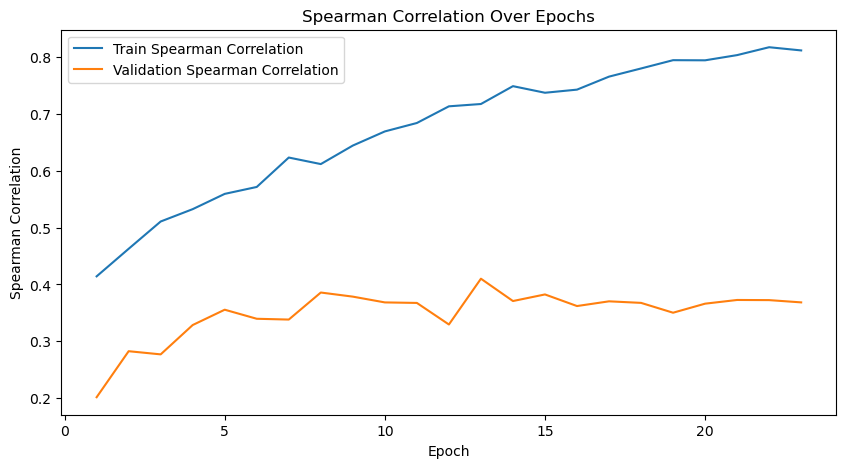

Spearman Correlation: 0.3685
Training with parameters: {'dropout': 0.1, 'embed_dim': 256, 'ff_dim': 128, 'learning_rate': 1e-05, 'num_heads': 8, 'num_layers': 4}
Epoch 1/25, Train Loss: 0.0125, Validation Loss: 0.0066, Train Corr: 0.3631, Val Corr: 0.3135
Epoch 2/25, Train Loss: 0.0106, Validation Loss: 0.0067, Train Corr: 0.4408, Val Corr: 0.3565
Epoch 3/25, Train Loss: 0.0100, Validation Loss: 0.0071, Train Corr: 0.4555, Val Corr: 0.3459
Epoch 4/25, Train Loss: 0.0097, Validation Loss: 0.0060, Train Corr: 0.5021, Val Corr: 0.3862
Epoch 5/25, Train Loss: 0.0088, Validation Loss: 0.0061, Train Corr: 0.5191, Val Corr: 0.3747
Epoch 6/25, Train Loss: 0.0092, Validation Loss: 0.0060, Train Corr: 0.5272, Val Corr: 0.3843
Epoch 7/25, Train Loss: 0.0087, Validation Loss: 0.0061, Train Corr: 0.5388, Val Corr: 0.3722
Epoch 8/25, Train Loss: 0.0087, Validation Loss: 0.0060, Train Corr: 0.5485, Val Corr: 0.3821
Epoch 9/25, Train Loss: 0.0085, Validation Loss: 0.0058, Train Corr: 0.5624, Val Corr:

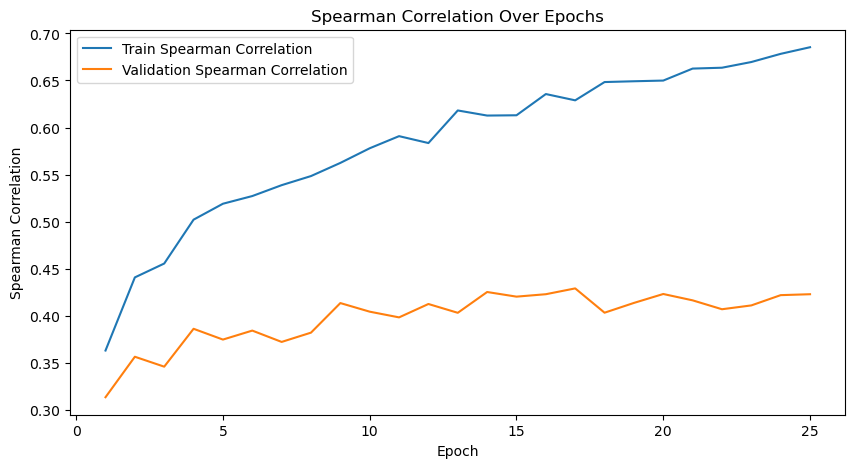

Spearman Correlation: 0.4229
Best Validation Spearman Correlation: 0.4433
Best Parameters: {'dropout': 0.1, 'embed_dim': 256, 'ff_dim': 64, 'learning_rate': 1e-05, 'num_heads': 8, 'num_layers': 2}


In [19]:
for params in ParameterGrid(param_grid):
    print(f"Training with parameters: {params}")
    model = DrugResponseModel(input_dim, embed_dim=params['embed_dim'], num_heads=params['num_heads'], 
                              num_layers=params['num_layers'], ff_dim=params['ff_dim'], dropout=params['dropout']).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=1e-5)
    
    train_model(model, train_loader, val_loader, criterion, optimizer, epochs=25, early_stopping_patience=10)
    val_corr = evaluate_model(model, val_loader)
    
    if val_corr > best_val_corr:
        best_val_corr = val_corr
        best_params = params

print(f"Best Validation Spearman Correlation: {best_val_corr:.4f}")
print(f"Best Parameters: {best_params}")

Training the best model with full training set
Epoch 1/100, Train Loss: 0.0174, Validation Loss: 0.0084, Train Corr: 0.4008, Val Corr: 0.3480
Epoch 2/100, Train Loss: 0.0117, Validation Loss: 0.0065, Train Corr: 0.4434, Val Corr: 0.3355
Epoch 3/100, Train Loss: 0.0109, Validation Loss: 0.0099, Train Corr: 0.4594, Val Corr: 0.3882
Epoch 4/100, Train Loss: 0.0106, Validation Loss: 0.0061, Train Corr: 0.5031, Val Corr: 0.4082
Epoch 5/100, Train Loss: 0.0094, Validation Loss: 0.0059, Train Corr: 0.5470, Val Corr: 0.4274
Epoch 6/100, Train Loss: 0.0096, Validation Loss: 0.0065, Train Corr: 0.5627, Val Corr: 0.4068
Epoch 7/100, Train Loss: 0.0090, Validation Loss: 0.0063, Train Corr: 0.5882, Val Corr: 0.4277
Epoch 8/100, Train Loss: 0.0082, Validation Loss: 0.0061, Train Corr: 0.6035, Val Corr: 0.4288
Epoch 9/100, Train Loss: 0.0083, Validation Loss: 0.0060, Train Corr: 0.6289, Val Corr: 0.4318
Epoch 10/100, Train Loss: 0.0085, Validation Loss: 0.0063, Train Corr: 0.6338, Val Corr: 0.4380
Ep

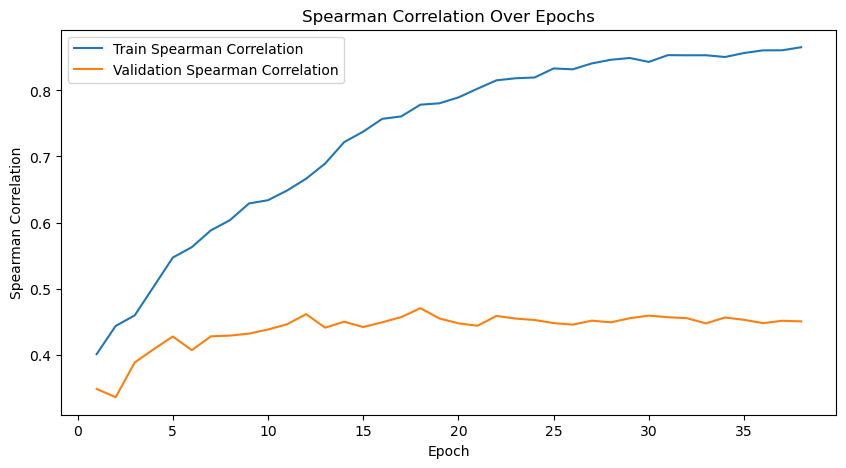

Spearman Correlation: 0.8583


0.8583403922498217

In [20]:
# Train the best model
print("Training the best model with full training set")
model = DrugResponseModel(input_dim, embed_dim=best_params['embed_dim'], num_heads=best_params['num_heads'], 
                          num_layers=best_params['num_layers'], ff_dim=best_params['ff_dim'], dropout=best_params['dropout']).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=1e-5)
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100, early_stopping_patience=20)

# Evaluate the model
evaluate_model(model, train_loader)

In [ ]:
# Predict AAC values for the test set
def predict(model, loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for features in loader:
            features = features.to(device)
            outputs = model(features)
            predictions.extend(outputs.view(-1).cpu().numpy())
    return predictions

test_predictions = predict(model, test_loader)

# Save predictions
out_dir = "/home/vivian.chu/vivian-sandbox/other/xAI-cancer-competition/vivian-models"
pd.DataFrame({'sampleId': test_data['sampleId'], 'AAC': test_predictions}).to_csv(f"{out_dir}/transformer_predictions.csv", index=False)

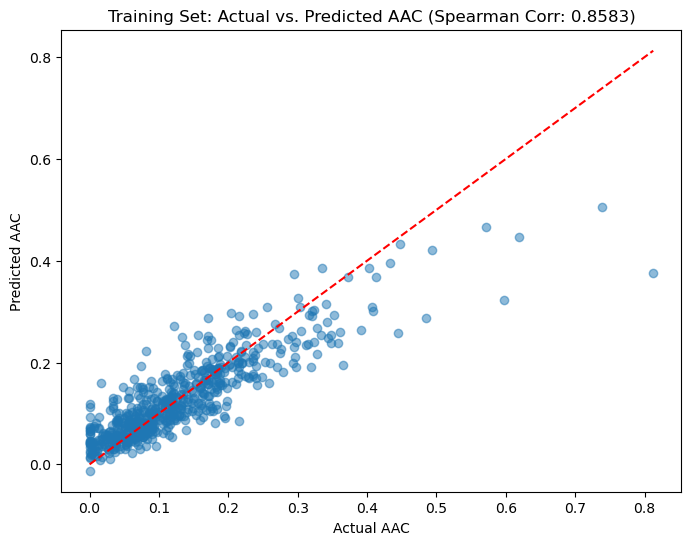

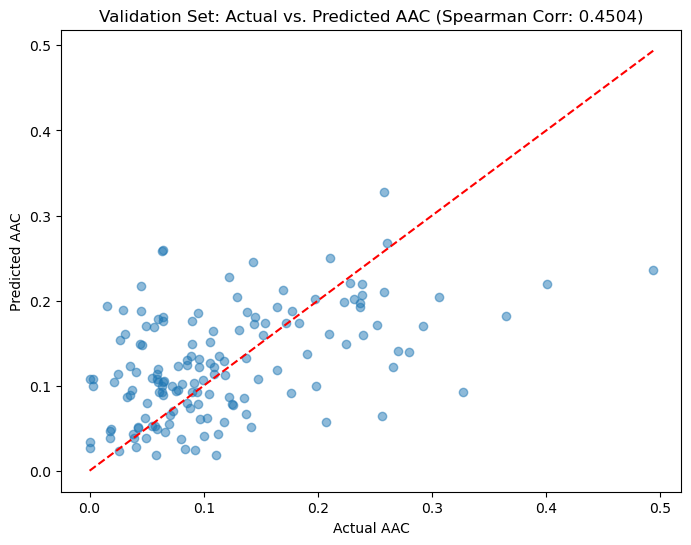

In [22]:
# Plot actual vs. predicted AAC for the training and validation sets
def plot_actual_vs_predicted(model, loader, title):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.view(-1).cpu().numpy())
    
    spearman_corr, _ = spearmanr(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    plt.scatter(all_labels, all_preds, alpha=0.5)
    plt.xlabel('Actual AAC')
    plt.ylabel('Predicted AAC')
    plt.title(f'{title} (Spearman Corr: {spearman_corr:.4f})')
    plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'r--')
    plt.show()

# Plot for training and validation sets
plot_actual_vs_predicted(model, train_loader, 'Training Set: Actual vs. Predicted AAC')
plot_actual_vs_predicted(model, val_loader, 'Validation Set: Actual vs. Predicted AAC')